# BAIT508_Industry_Analysis
David Chen (30409156)
Wanting Xu (81971392)

## Part 1. Quantitative Analysis of the Industry Sector

In [2]:
# Package Imports and Data Loading
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import warnings
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from DocumentSimilarity import DocumentSimilarity

nltk.download('stopwords')

warnings.filterwarnings('ignore')

#Load the data of major industry sectors and their corresponding codes
dataFrameMajorGroup = pd.read_csv('data/major_groups.csv')

dataFrame10K = pd.read_csv('data/2020_10K_item1_full.csv')

dataFramePublicFirms = pd.read_csv('data/public_firms.csv')

print(dataFrameMajorGroup.head())
print(dataFramePublicFirms.head())
print(dataFrame10K.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   major_group                                        description
0            1                      Agricultural Production Crops
1            2  Agriculture production livestock and animal sp...
2            7                              Agricultural Services
3            8                                           Forestry
4            9                       Fishing hunting and trapping
   gvkey  fyear location      conm     ipodate   sic  prcc_c      ch      ni  \
0   1004   1994      USA  AAR CORP  1988/01/01  5080  13.375  22.487  10.463   
1   1004   1995      USA  AAR CORP  1988/01/01  5080  22.000  33.606  16.012   
2   1004   1996      USA  AAR CORP  1988/01/01  5080  30.250  51.705  23.025   
3   1004   1997      USA  AAR CORP  1988/01/01  5080  38.750  17.222  35.657   
4   1004   1998      USA  AAR CORP  1988/01/01  5080  23.875   8.250  41.671   

     asset     sale       roa  
0  425.814  451.395  0.024572  
1  437.846  504.990  0.036570  
2  529.584  589.328  0.0434

### A. Industry Sector Selection and Data Filtering

#### 1. 
List of major industry sectors and their corresponding codes has been loaded as dataframe `dataFrameMajorGroup`. Among the major industries listed we propose to look into [Industry Name]

In [3]:
selectedMajorGroupCode = 51

#### 2.

In [4]:
# Filter the data in "data/public_firms.csv" to only include the firms belonging to the industry sector(s) you have selected.
def filterByIndustry(dataFrame, majorGroupCode):
    return dataFrame[dataFrame['sic']//100 == majorGroupCode]

filteredPublicFirms = filterByIndustry(dataFramePublicFirms, selectedMajorGroupCode)

print(filteredPublicFirms)

         gvkey  fyear location                      conm ipodate   sic  \
368       1094   1995      USA                ACETO CORP     NaN  5160   
369       1094   1996      USA                ACETO CORP     NaN  5160   
370       1094   1997      USA                ACETO CORP     NaN  5160   
371       1094   1998      USA                ACETO CORP     NaN  5160   
372       1094   1999      USA                ACETO CORP     NaN  5160   
...        ...    ...      ...                       ...     ...   ...   
207716  264393   2016      USA  INNOVATIVE FOOD HOLDINGS     NaN  5140   
207717  264393   2017      USA  INNOVATIVE FOOD HOLDINGS     NaN  5140   
207718  264393   2018      USA  INNOVATIVE FOOD HOLDINGS     NaN  5140   
207719  264393   2019      USA  INNOVATIVE FOOD HOLDINGS     NaN  5140   
207720  264393   2020      USA  INNOVATIVE FOOD HOLDINGS     NaN  5140   

        prcc_c     ch     ni   asset     sale       roa  
368     16.000  1.644  7.756  86.116  164.783  0.0900

#### 3.

In [5]:
#a.How many unique firm-year ("fyear") observations are there in the filtered dataset?
numFyear =len(filteredPublicFirms.groupby('fyear'))

print(f'There are {numFyear} unique firm-year ("fyear") observations in the filtered dataset')

There are 27 unique firm-year ("fyear") observations in the filtered dataset


In [6]:
# b.How many unique firms are there in the filtered dataset?
numUniqueFirms = len(filteredPublicFirms.groupby('gvkey'))
print(f'There are {numUniqueFirms} unique firms in the filtered dataset')

There are 277 unique firms in the filtered dataset


In [7]:
# c. How many firms in the filtered dataset have records over all 27 years (1994-2020)?
gvKeyYear = filteredPublicFirms.groupby('gvkey').count()[['fyear']]

numFirmsRecordesAllYears = len(gvKeyYear[gvKeyYear['fyear'] == 27])

print(f'There are {numFirmsRecordesAllYears} firms in the filtered dataset have records over all 27 years (1994-2020)')


There are 4 firms in the filtered dataset have records over all 27 years (1994-2020)


### B. Preliminary Analysis

In [8]:
def topFirms(column, numFirms, fy = 0):
    if fy == 0:
        dataFrame = filteredPublicFirms
    else:
        dataFrame = filteredPublicFirms[filteredPublicFirms['fyear'] == fy]
    return dataFrame.sort_values(by=column, ascending=False).head(numFirms)

In [9]:
#1.	What are the top 10 firms with the highest stock price (column "prcc_c") in the year 2020?
topFirms('prcc_c', 10, 2020)

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
24707,7171,2020,USA,MCKESSON CORP,NaN,5122,173.92,6278.000,-4539.000,65015.000,238228.000,-0.069815
119266,61122,2020,USA,AMCON DISTRIBUTING CO,1995/08/04,5190,118.95,0.661,5.543,188.001,1127.979,0.029484
112130,31673,2020,USA,AMERISOURCEBERGEN CORP,1995/04/04,5122,97.76,4597.746,-3408.716,44274.830,189893.926,-0.076990
37549,10247,2020,USA,SYSCO CORP,NaN,5140,74.26,6059.427,215.475,22628.266,52893.310,0.009522
175383,147708,2020,USA,CALAVO GROWERS INC,NaN,5140,69.43,4.055,-13.625,429.624,1059.371,-0.031714
6848,2751,2020,USA,CARDINAL HEALTH INC,NaN,5122,53.56,2771.000,-3696.000,40766.000,152922.000,-0.090664
17958,5530,2020,USA,HAWKINS INC,NaN,5160,52.31,2.998,40.980,472.550,596.871,0.086721
40945,11017,2020,USA,UNIVERSAL CORP/VA,NaN,5150,48.61,197.221,87.410,2341.924,1983.357,0.037324
55415,14269,2020,USA,HERBALIFE NUTRITION LTD,NaN,5122,48.05,1045.400,372.600,3076.100,5541.800,0.121127
98338,28787,2020,USA,PERFORMANCE FOOD GROUP CO,1993/08/24,5140,47.61,420.700,-114.100,7719.700,25086.300,-0.014780


In [10]:
#2.	What are the top 10 firms with the highest sales (column "sale") in the entire history of the dataset?
topFirms('sale', 10)

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
24707,7171,2020,USA,MCKESSON CORP,NaN,5122,173.92,6278.000,-4539.000,65015.000,238228.000,-0.069815
24706,7171,2019,USA,MCKESSON CORP,NaN,5122,138.32,NaN,900.000,61247.000,231051.000,0.014695
24705,7171,2018,USA,MCKESSON CORP,NaN,5122,110.47,2981.000,34.000,59672.000,214319.000,0.000570
24704,7171,2017,USA,MCKESSON CORP,NaN,5122,155.95,2672.000,67.000,60381.000,208357.000,0.001110
24703,7171,2016,USA,MCKESSON CORP,NaN,5122,140.45,NaN,5070.000,60969.000,198533.000,0.083157
24702,7171,2015,USA,MCKESSON CORP,NaN,5122,197.23,NaN,2258.000,56563.000,190884.000,0.039920
112130,31673,2020,USA,AMERISOURCEBERGEN CORP,1995/04/04,5122,97.76,4597.746,-3408.716,44274.830,189893.926,-0.076990
112129,31673,2019,USA,AMERISOURCEBERGEN CORP,1995/04/04,5122,85.02,3374.194,855.365,39171.980,179589.121,0.021836
24701,7171,2014,USA,MCKESSON CORP,NaN,5122,207.58,5341.000,1476.000,53870.000,179045.000,0.027399
112128,31673,2018,USA,AMERISOURCEBERGEN CORP,1995/04/04,5122,74.40,2492.516,1658.405,37669.838,167939.635,0.044025


In [11]:
#3.	What is the geographical distribution (column "location") of all the firms? In other words, how many firms are there in each location? Please list the top 10 locations. 
topLocations = filteredPublicFirms.groupby('location')[['gvkey']].count().sort_values(by='gvkey', ascending=False).head(10)
topLocations

,gvkey
location,
USA,2086
CHN,48
ISR,42
HKG,38
BRA,38
GBR,29
MEX,17
RUS,17
CHE,12


<Axes: xlabel='fyear'>

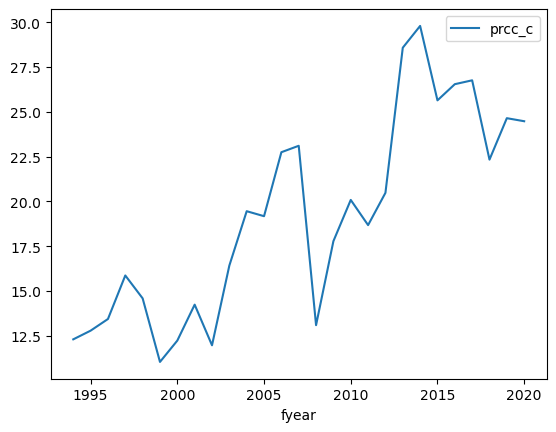

In [12]:
#4.	Create a line chart to show the average stock price (column "prcc_c") in the selected sector(s) across the years. If you have selected multiple sectors, draw multiple lines to show them separately.
meanStockPrice = filteredPublicFirms.groupby('fyear')[['prcc_c']].mean()
meanStockPrice.plot.line()

In [13]:
#5.	Which firm was affected the most by the 2008 Financial Crisis, as measured by the percentage drop in stock price from 2007 to 2008?
# ideation by ChatGPT

df_2007 = filteredPublicFirms[filteredPublicFirms['fyear'] == 2007]
df_2008 = filteredPublicFirms[filteredPublicFirms['fyear'] == 2008]

avg_price_2007 = df_2007.groupby('gvkey')['prcc_c'].mean()
avg_price_2008 = df_2008.groupby('gvkey')['prcc_c'].mean()

percentage_drop = ((avg_price_2008 - avg_price_2007) / avg_price_2007) * 100

most_affexted_gvkey = percentage_drop.idxmin()
most_affected_conm = df_2008[df_2008['gvkey'] == most_affexted_gvkey]['conm'].values[0]
max_drop = abs(percentage_drop.min())

print(f"The firm most affected by the 2008 Financial Crisis is {most_affected_conm} (gvkey: {most_affexted_gvkey}) with a drop of {max_drop}%.")

The firm most affected by the 2008 Financial Crisis is CENTRAL ENERGY PARTNERS LP (gvkey: 161977) with a drop of 92.70588235294117%.


<Axes: xlabel='fyear'>

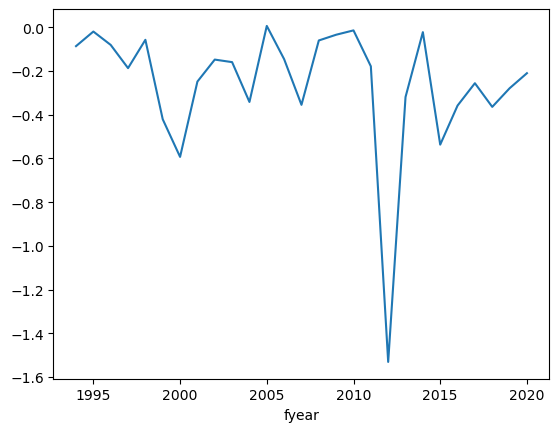

In [14]:
#6.	Plot the average Return on Assets (ROA) for the firms located in the “USA” across the years. ROA is calculated as ni/asset.
df_usa = filteredPublicFirms[filteredPublicFirms['location'] == 'USA']
df_usa['roa'] = df_usa['ni'] / df_usa['asset']
avg_return_on_assets = df_usa.groupby('fyear')['roa'].mean()
avg_return_on_assets.plot.line()

## Part 2. Text Analysis on the Industry Sector

### C. Text Cleaning

In [16]:
translator = str.maketrans('', '', string.punctuation)
sw = stopwords.words('english')

# Copied from 'nlp part 2 text cleaning and keyword extraction-ba1.ipynb'
def clean_text(text):
    #1.	Convert all words to lowercase.
    clean_text = text.lower()

    #2.	Remove punctuations.
    clean_text = clean_text.translate(translator)

    #3.	Remove stop words based on the list of English stop words in NLTK.
    clean_words = [w for w in clean_text.split() if w not in sw]
    
    return ' '.join(clean_words)

dataFrame10K['item_1_clean'] = dataFrame10K['item_1_text'].apply(clean_text)

dataFrame10K.head()


,cik,year,name,item_1_text,gvkey,item_1_clean
0,1041588,2020,ACCESS-POWER INC,fixed expenses are previosuly documented in an...,66119,fixed expenses previosuly documented 8k 235000...
1,315374,2020,HURCO COMPANIES INC,"General Hurco Companies, Inc. is an internatio...",5788,general hurco companies inc international indu...
2,1622996,2020,"ACRO BIOMEDICAL CO., LTD.",We have been engaged in the business of develo...,27584,engaged business developing marketing products...
3,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614,corporate history chun capital group formerly ...
4,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614,corporate history chun capital group formerly ...


### D. Keyword Analysis

In [50]:
#1.	Create a new DataFrame that includes only firms in your selected industry sectors. Ensure that you merge the 10-K data with the previous "public_firm.csv" data using an inner join.
# generated from github copilot
df_selected_industry = pd.merge(dataFrame10K, filteredPublicFirms, left_on=['gvkey', 'year'], right_on=['gvkey', 'fyear'], how='inner')
df_selected_industry.head()

,cik,year,name,item_1_text,gvkey,item_1_clean,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
0,1007019,2020,COFFEE HOLDING CO INC,General Overview Products and Operations. We a...,160742,general overview products operations integrate...,2020,USA,COFFEE HOLDING CO INC,2005/05/03,5140,3.84,2.875,-0.094,38.480,74.336,-0.002443
1,1665918,2020,US Foods Holding Corp.,US Foods Holding Corp. and its consolidated su...,18312,us foods holding corp consolidated subsidiarie...,2020,USA,US FOODS HOLDING CORP,2016/05/26,5140,33.31,828.000,-226.000,12423.000,22885.000,-0.018192
2,1176334,2020,MARTIN MIDSTREAM PARTNERS L.P.,"References in this annual report to we, our...",150201,references annual report us like terms used hi...,2020,USA,MARTIN MIDSTREAM PARTNERS LP,2002/11/01,5172,1.43,4.958,-6.771,579.638,672.142,-0.011681
3,1180262,2020,HERBALIFE NUTRITION LTD.,"GENERAL Founded in 1980, we are a global nutri...",14269,general founded 1980 global nutrition company ...,2020,USA,HERBALIFE NUTRITION LTD,NaN,5122,48.05,1045.400,372.600,3076.100,5541.800,0.121127
4,1552275,2020,Sunoco LP,"General As used in this document, the terms P...",12892,general used document terms partnership sun us...,2020,USA,SUNOCO LP,NaN,5172,28.78,97.000,212.000,5267.000,10710.000,0.040251


In [18]:
#2.	Generate the top 10 keywords for each firm based on two different methods: word counts and TF-IDF score.
def get_keywords_wc(text):
    c = Counter(text.split())
    words = []
    for pair in c.most_common(10):
        words.append(pair[0])
    return ' '.join([x[0] for x in c.most_common(10)])

def get_keywords_tfidf(document_list):
    '''
    Input: A list of documents (text)
    Output: The corresponding top 10 keywords for each document based on tf-idf values
    '''

    # Step 1: Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Step 2: Calculate the TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(document_list)

    # Step 3: Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Step 4: Extract top 10 keywords for each text
    top_keywords = []
    for i in range(len(document_list)):

        if i %100 == 0:
            print(f'Processing the {i}/{len(document_list)} document.')
        
        feature_index = tfidf_matrix[i, :].nonzero()[1]
        tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])
        sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
        top_keywords.append(' '.join([feature_names[i] for i, _ in sorted_tfidf_scores[:10]]))
    
    return top_keywords

wc_keywords = df_selected_industry['item_1_clean'].apply(get_keywords_wc)
df_selected_industry['keyword_clean_wc'] =  wc_keywords
tfidf_keywords = get_keywords_tfidf(df_selected_industry['item_1_clean'].tolist())
df_selected_industry['keyword_clean_tfidf'] =  tfidf_keywords

df_selected_industry[['gvkey', 'conm', 'keyword_clean_wc', 'keyword_clean_tfidf']]

Processing the 0/53 document.


,gvkey,conm,keyword_clean_wc,keyword_clean_tfidf
0,160742,COFFEE HOLDING CO INC,coffee green specialty market ● united states ...,coffee green coffees beans espresso specialty ...
1,18312,US FOODS HOLDING CORP,us food president customers products mr vice s...,vice mr president us foodservice served food c...
2,150201,MARTIN MIDSTREAM PARTNERS LP,us sulfur products services transportation man...,sulfur martin marine terminals resource transp...
3,14269,HERBALIFE NUTRITION LTD,products members sales marketing us product nu...,members products nutrition herbalife sales mem...
4,12892,SUNOCO LP,fuel motor retail distribution operations stat...,fuel motor eto retail dealers gasoline sunoco ...
5,7882,NEWPARK RESOURCES,fluids drilling services customers systems seg...,fluids drilling mats ep composite mat segment ...
6,186960,CHEFS' WAREHOUSE INC,products customers food sales product customer...,culinary products customers food centerofthepl...
7,21515,UNIVAR SOLUTIONS INC,products chemical chemicals services ingredien...,chemical chemicals producers ingredients produ...
8,15212,CROSSAMERICA PARTNERS LP,fuel motor retail sites • wholesale 2019 distr...,motor fuel circle sites dms retail lease whole...
9,28762,SPARTANNASH CO,company products retail distribution stores fo...,company deca military commissaries retail stor...


In [19]:
#3.	Create two wordclouds to visualize the keywords across all firms in the selected sector: one based on the word count of keywords and another based on the TF-IDF score.
# UDF to create wordcloud
def create_wordcloud(text):
    wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(text) # note that text is a string, not a list

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud1)
    plt.savefig('keyword_wc.png') # save as PNG file
    plt.axis('off')

    plt.show()

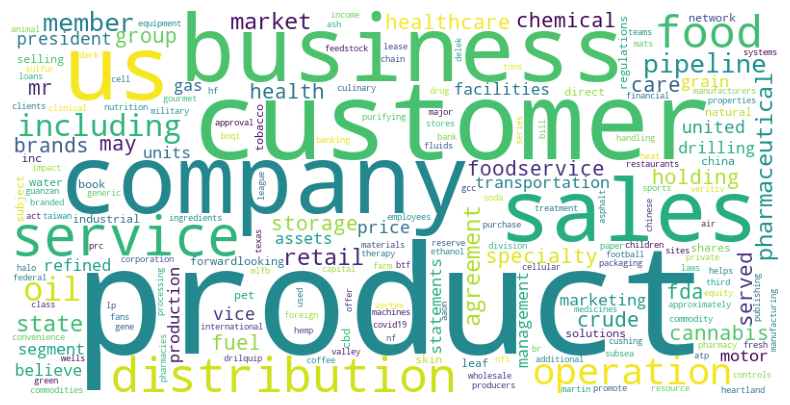

In [20]:
# Wordcloud based on word count
text_wc = ' '.join(df_selected_industry['keyword_clean_wc'].tolist())
create_wordcloud(text_wc)

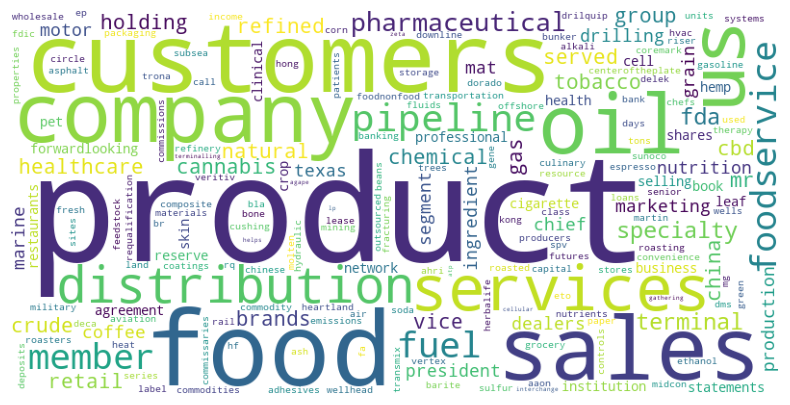

In [21]:
# Wordcloud based on TF-IDF score
text_tfidf = ' '.join(df_selected_industry['keyword_clean_tfidf'].tolist())
create_wordcloud(text_tfidf)

### E. Word Embedding

In [ ]:
#1.	Train a word2vec model with the full 10-K sample (e.g., "data/2020_10K_item1_full.csv"). Please use the cleaned text (e.g., results from Step C) for training.
sent = [row.split() for row in dataFrame10K['item_1_clean']]
model = Word2Vec(sent, min_count=1, vector_size=50, workers=3, window=3, sg = 1)

In [ ]:
model.save("word2vec.model")

In [22]:
#2.	Manually inspect the wordclouds you generated in D.3 and choose three representative keywords that are relevant to the industry sector of your interest. Utilize the trained word2vec model to find the most relevant five words for each of these three keywords.
model = Word2Vec.load("word2vec.model")

model.wv.most_similar('product', topn=5)

[('sf3', 0.8315339088439941),
 ('sugardown®', 0.8162137269973755),
 ('products', 0.8113241791725159),
 ('biologic', 0.8029415011405945),
 ('contrapest', 0.7941645383834839)]

In [23]:
model.wv.most_similar('customers', topn=5)

[('clients', 0.9128187894821167),
 ('endusers', 0.8987087607383728),
 ('endcustomers', 0.8938390612602234),
 ('customer', 0.8857874274253845),
 ('enduser', 0.877415657043457)]

In [24]:
model.wv.most_similar('oil', topn=5)

[('gas', 0.954869270324707),
 ('crude', 0.9254370331764221),
 ('natural', 0.9091117978096008),
 ('condensate', 0.8609809279441833),
 ('hydrocarbon', 0.8570497632026672)]

## Part 3. Comprehensive Analysis of One Sample Firm

### F. Firm Analysis and Strategy Suggestion

In [25]:
#1.	Convert the keywords extracted in D.2 into word embeddings with the word2vec model trained in E.1. Add up the embeddings for each firm to create the firm-level embeddings. Use the firm-level embeddings to find the focal firm’s competing firms (or, most similar firms). 
df = df_selected_industry[['gvkey', 'conm', 'keyword_clean_tfidf']]
d = DocumentSimilarity(model = model, gvkeys=df['gvkey'], conm = df['conm'], keywordslist = df['keyword_clean_tfidf'])

In [27]:
# SUNOCO LP is the focal firm
focal_gvkey = 12892
df[df.gvkey == focal_gvkey]

,gvkey,conm,keyword_clean_tfidf
4,12892,SUNOCO LP,fuel motor eto retail dealers gasoline sunoco ...


In [29]:
d.get_firm_embedding(firm = focal_gvkey)

array([-0.09655063,  0.21685846,  0.01957438, -0.01058974, -0.14753446,
       -0.09830879,  0.04956182,  0.09720557, -0.15060829,  0.03296605,
       -0.18776774, -0.07311377,  0.06450308,  0.05214577,  0.03462483,
        0.14607391,  0.09266666,  0.11565232, -0.1413295 , -0.09087457,
        0.02881193,  0.17605108,  0.10314731,  0.08081623, -0.06379596,
        0.049173  , -0.25237575, -0.10519687, -0.06105955, -0.06458598,
        0.0631474 , -0.14828482, -0.17910455,  0.07483212,  0.01060607,
        0.02219306,  0.03169478, -0.02701788,  0.12037502, -0.05972804,
        0.00806471,  0.05338281, -0.11922814,  0.13266395,  0.00334349,
        0.2290556 ,  0.1203716 ,  0.01153137,  0.01810366, -0.0026446 ],
      dtype=float32)

In [39]:
competitors = d.most_similar(firm = focal_gvkey, topn = 5)
competitors

[(15212, 'CROSSAMERICA PARTNERS LP', 0.91524917),
 (187709, 'SPRAGUE RESOURCES LP', 0.91149354),
 (134464, 'CHS INC', 0.89233893),
 (150201, 'MARTIN MIDSTREAM PARTNERS LP', 0.8791456),
 (1659, 'ANDERSONS INC', 0.87617457)]

In [54]:
#2.	Compare the revenue, market share, and ROA of the focal firm to its competitors and provide suggestions accordingly.
gvkeys = [focal_gvkey] + [x[0] for x in competitors]
df_focal = df_selected_industry[df_selected_industry['gvkey'].isin(gvkeys)][['fyear', 'gvkey', 'conm', 'sale', 'ni', 'asset', 'roa']]
df_focal['market_share%'] = (df_focal['sale'] / df_focal['sale'].sum()) * 100
df_focal

,fyear,gvkey,conm,sale,ni,asset,roa,market_share%
2,2020,150201,MARTIN MIDSTREAM PARTNERS LP,672.142,-6.771,579.638,-0.011681,1.289510
4,2020,12892,SUNOCO LP,10710.000,212.000,5267.000,0.040251,20.547228
8,2020,15212,CROSSAMERICA PARTNERS LP,1790.894,107.456,1014.342,0.105937,3.435846
13,2020,1659,ANDERSONS INC,8208.436,7.710,4272.121,0.001805,15.747956
19,2020,187709,SPRAGUE RESOURCES LP,2335.983,33.811,1199.430,0.028189,4.481604
47,2020,134464,CHS INC,28406.365,422.439,15993.947,0.026412,54.497857


In [55]:
#3.	Perform an analysis of the historical stock prices, ROA, revenue, and assets of the chosen company. Investigate potential correlations and address noteworthy decreases and increases.
df_focal_firm_history = filteredPublicFirms[filteredPublicFirms['gvkey'] == focal_gvkey][['fyear', 'prcc_c', 'roa', 'sale', 'asset']]
df_focal_firm_history['roa%'] = df_focal_firm_history['roa'] * 100
df_focal_firm_history

,fyear,prcc_c,roa,sale,asset,roa%
49374,2010,NaN,0.045492,2683.792,202.587,4.549157
49375,2011,NaN,0.045816,3820.378,231.316,4.581611
49376,2012,25.16,0.049382,4277.341,355.800,4.938168
49377,2013,33.10,0.094921,4492.579,390.084,9.492058
49378,2014,49.77,0.025822,5382.016,2197.481,2.582184
49379,2015,39.61,0.020780,16935.347,6247.583,2.077956
49380,2016,26.89,-0.046661,15698.000,8701.000,-4.666130
49381,2017,28.40,0.017857,11723.000,8344.000,1.785714
49382,2018,27.19,-0.042427,16994.000,4879.000,-4.242673
49383,2019,30.60,0.057558,16596.000,5438.000,5.755793


In [44]:
cols = ['prcc_c', 'roa', 'sale', 'asset']
df_focal_firm_history[cols].corr()

,prcc_c,roa,sale,asset
prcc_c,1.000000,0.180060,-0.227195,-0.230982
roa,0.180060,1.000000,-0.608102,-0.631544
sale,-0.227195,-0.608102,1.000000,0.851376
asset,-0.230982,-0.631544,0.851376,1.000000


[]

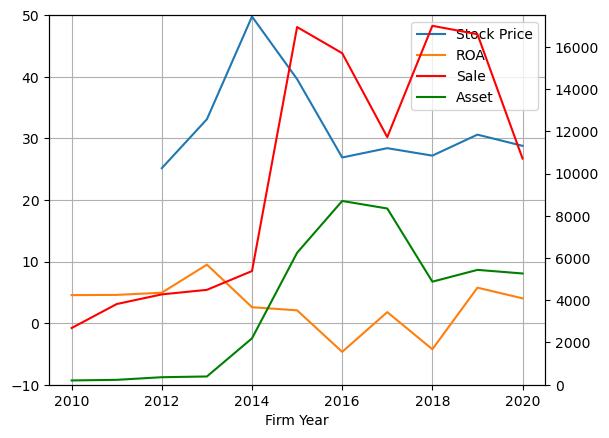

In [62]:
fyear = df_focal_firm_history['fyear'].tolist()
stock_price = df_focal_firm_history['prcc_c'].tolist()
roa = df_focal_firm_history['roa%'].tolist()
sale = df_focal_firm_history['sale'].tolist()
asset = df_focal_firm_history['asset'].tolist()

fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(fyear, stock_price, '-', label = 'Stock Price')
lns2 = ax.plot(fyear, roa, '-', label = 'ROA')
ax2 = ax.twinx()
lns3 = ax2.plot(fyear, sale, '-r', label = 'Sale')
lns4 = ax2.plot(fyear, asset, '-g', label = 'Asset')

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.grid()
ax.set_xlabel("Firm Year")
ax2.set_ylim(0, 17500)
ax.set_ylim(-10, 50)
plt.plot()

## That's all for this notebook on industry analysis assignment, thanks!